In [1]:
import os
import sys

import numpy as np
import pandas as pd

import datetime as dt

import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

from datetime import date
from tqdm import tqdm

from sklearn.metrics import mean_squared_error

sys.path.append('../../')
from model.gr4j_np import GR4J
from dataset.cotter_dataset import CotterData

In [2]:
np.random.seed(42)
%matplotlib inline
%load_ext autoreload

In [3]:
train_dates = (dt.datetime(1990, 1, 1), dt.datetime(2004, 12, 31))
val_dates = (dt.datetime(2005, 1, 1), dt.datetime(2014, 12, 31))

ds = CotterData(
    config_file='../../dataset/dataconfig.yml', 
    train_dates=train_dates, val_dates=val_dates,
    scale=False,
    create_seq=False,
    X_col=['daily_rain', 'et_tall_crop']
)

In [4]:
X_train, y_train = [t.detach().numpy() for t in ds.trainset.tensors]
X_val, y_val = [t.detach().numpy() for t in ds.valset.tensors]

In [5]:
def nse(targets, predictions):
    return 1-(np.sum((targets-predictions)**2)/np.sum((targets-np.mean(targets))**2))

def normalize(x):
    return 1/(2 - x)

In [6]:
class MCMC:

    def generate_sample(self, theta_c):
        raise("Implement in the subclass!")
    
    def run_sampling(self, N=1000):
        # Initialize samples
        samples = np.zeros((N, self.dim))

        # First sample
        samples[0] = self.init_params()
        print(samples[0])

        # Count of accepted samples
        N_accepted = 0

        pbar = tqdm(range(N-1))

        # Start sampling
        for n in pbar:
            
            # Generate proposal
            theta_c = samples[n]
            samples[n + 1], score, accepted = self.generate_sample(theta_c)

            if accepted:
                N_accepted += 1

            
            pbar.set_description(f'Accepted: {N_accepted/(n+1):.2f} Score: {score:.2f}')

            if n + 1 % 1000==0:
                fig, axs = plt.subplots(1, 5, figsize=(16, 3))
                sns.lineplot(samples[:n+1, 0], ax=axs[0]).set_title('X1')
                sns.lineplot(samples[:n+1, 1], ax=axs[1]).set_title('X2')
                sns.lineplot(samples[:n+1, 2], ax=axs[2]).set_title('X3')
                sns.lineplot(samples[:n+1, 3], ax=axs[3]).set_title('X4')
                sns.lineplot(samples[:n+1, 4], ax=axs[4]).set_title('tau')
                plt.show()
            
        
        print(f"Acceptance ratio: {N_accepted/N:.2f}")
        
        return samples, N_accepted

    def plot_samples(self, samples):
        fig, ax = plt.subplots(figsize=(8, 5))
        ax.grid(alpha = 0.2)
        ax.hist(samples, bins=50, alpha=0.6, density=True)
        ax.set_title("Sampled Distribution")
        return ax


In [7]:
class Parameter(object):

    def __init__(self, name, dist):
        self.name = name
        self.dist = dist

    def logpdf(self, x):
        return self.dist.logpdf(x)


class RWGR4J(MCMC):
    def __init__(self, X, y, epsilon=[10, 0.1, 10, 0.1, 0.1]):
        self.epsilon = epsilon
        self.gr4j = GR4J()
        self.prcp = X[:, 0]
        self.etp = X[:, 1]
        self.flow = y[:, 0]
        self.dim=5

        self.params = {
            'x1': Parameter('x1', stats.norm(loc=500, scale=50)),
            'x2': Parameter('x2', stats.norm(loc=-2.5, scale=3)),
            'x3': Parameter('x3', stats.norm(loc=200, scale=50)),
            'x4': Parameter('x4', stats.invgamma(a=0.5, loc=0, scale=1)),
            'tau': Parameter('tau', stats.expon())
        }
    
    def init_params(self):
        theta_0 = []
        for n, p in self.params.items():
            theta_0.append(p.dist.rvs(1)[0])

        self.gr4j.update_params(*theta_0[:-1])
        theta_0[-1] = np.var(self.gr4j.run(self.prcp, self.etp)[0] - self.flow)
        
        return np.array(theta_0)
    
    def log_prior(self, x1, x2, x3, x4, tau):
        p1 = self.params['x1'].logpdf(x1)
        p2 = self.params['x2'].logpdf(x2)
        p3 = self.params['x3'].logpdf(x3)
        p4 = self.params['x4'].logpdf(x4)
        ptau = self.params['tau'].logpdf(tau)
        return p1 + p2 + p3 + p4 + ptau


    def log_gauss_likelihood(self, pred, target, tau):
        return stats.norm.logpdf(pred, loc=target, scale=tau)
    
    def generate_sample(self, theta_c):
        
        # Proposal
        n = np.random.randn(5)
        theta_p = theta_c + self.epsilon * n

        # GR4J
        self.gr4j.update_params(*theta_c[:-1])
        flow_c = self.gr4j.run(self.prcp, self.etp)[0]
        self.gr4j.update_params(*theta_p[:-1])
        flow_p = self.gr4j.run(self.prcp, self.etp)[0]

        # Evaluate acceptance prob
        log_pos_c = self.log_prior(*theta_c) + self.log_gauss_likelihood(flow_c, self.flow, theta_c[-1]).sum()
        log_pos_p = self.log_prior(*theta_p) + self.log_gauss_likelihood(flow_p, self.flow, theta_p[-1]).sum()

        # MH-accept ratio
        delta_log_pos = log_pos_p - log_pos_c
        alpha = min(1, np.exp(delta_log_pos))
        
        u = np.random.uniform(0, 1)

        # Accept/Reject
        if alpha > u:
            return theta_p, nse(self.flow, flow_p), True
        else:
            return theta_c, nse(self.flow, flow_c), False

In [8]:
rw_gr4j = RWGR4J(
    X_train, y_train,
    epsilon=[5, 0.5, 5, 0.1, 0.1]
)

In [9]:
samples, n_accepted = rw_gr4j.run_sampling(2000)

[524.83570765  -2.9147929  232.38442691   0.99383967   0.61942949]


Accepted: 0.02 Score: 0.62: 100%|██████████| 1999/1999 [03:35<00:00,  9.26it/s]

Acceptance ratio: 0.02


Text(0.5, 1.0, 'tau')

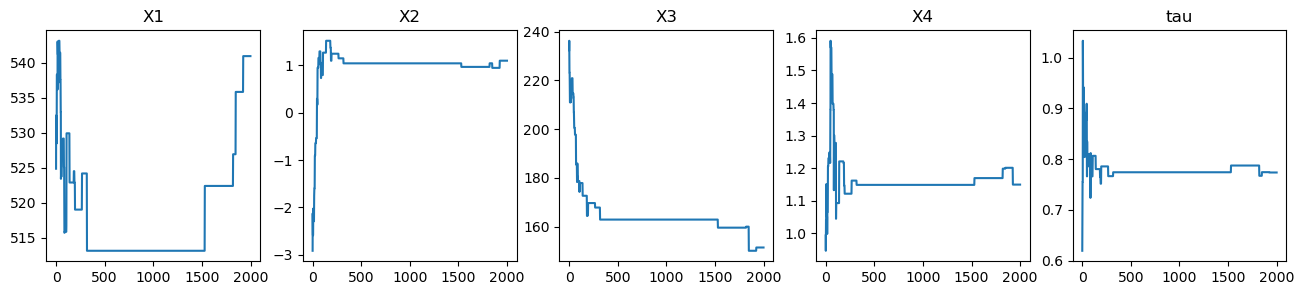

In [10]:
fig, axs = plt.subplots(1, 5, figsize=(16, 3))
sns.lineplot(samples[:, 0], ax=axs[0]).set_title('X1')
sns.lineplot(samples[:, 1], ax=axs[1]).set_title('X2')
sns.lineplot(samples[:, 2], ax=axs[2]).set_title('X3')
sns.lineplot(samples[:, 3], ax=axs[3]).set_title('X4')
sns.lineplot(samples[:, 4], ax=axs[4]).set_title('tau')

In [13]:
def evaluate(model, et, prcp, flow):
    
    flow_pred = model.run(prcp, et)[0]

    nse_score = nse(flow, flow_pred)
    nnse_score = normalize(nse_score)

    print(f"NSE: {nse_score:.3f}")
    print(f"Normalized NSE: {nnse_score:.3f}")

    fig, ax = plt.subplots(figsize=(16, 6))
    ax.plot(flow, color='black', label='obs', alpha=0.8)
    ax.plot(flow_pred, color='red', label='pred', alpha=1.0)
    # ax.plot(prcp, 'g--', label='precip', alpha=0.45)
    # ax.plot(et, 'y--', label='etp', alpha=0.45)
    

    ax.set_xlabel('Date')
    ax.set_ylabel('Flow')

    plt.legend()

    return flow_pred, flow

NSE: 0.681
Normalized NSE: 0.758


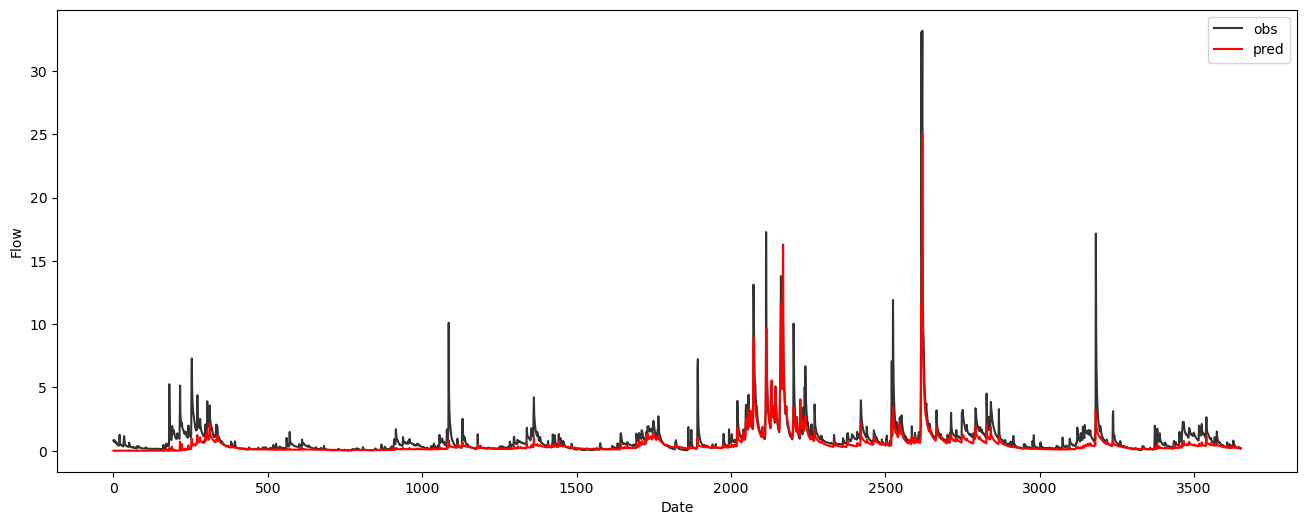

In [16]:
# Evaluate on unseen data
prcp_holdout = X_val[:, 0]
et_holdout= X_val[:, 1]
flow_holdout = y_val[:, 0]
# date_holdout = holdout_data.loc[:, 'Date'].values


rw_gr4j.gr4j.update_params(*samples.mean(0)[:-1])

flow_pred, flow = evaluate(rw_gr4j.gr4j, et_holdout, prcp_holdout, flow_holdout)